# Node Classification on Facebook Large Page-Page Network

## About dataset

This webgraph is a page-page graph of verified Facebook sites. This graph was collected through the Facebook Graph API in November 2017 and restricted to pages from 4 categories which are defined by Facebook. These categories are: politicians, governmental organizations, television shows and companies. The task related to this dataset is multi-class node classification for the 4 site categories.

[musae_facebook_target.csv](https://raw.githubusercontent.com/TimKong21/MEMGRAPH-Graph-Analytics-with-NetworkX/main/Asssignments/Assignment%205_Graph%20embeddings%20_machine%20learning/facebook_large/musae_facebook_target.csv)
1. Nodes are the oficial Facebook pages with unique id.
2. Each page is labelled with the page type - 'tvshow', 'government', 'company', 'politician'

[musae_facebook_edges.csv](https://raw.githubusercontent.com/benedekrozemberczki/MUSAE/master/input/edges/facebook_edges.csv) 
1. Edges are the mutual likes between the Facebook pages

## Import necessary modules

In [1]:
import networkx as nx
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk

%matplotlib inline

## Data importation and preprocessing

### Edges data 

In [2]:
edges = pd.read_csv('facebook_large/musae_facebook_edges.csv')
print('shape:',edges.shape)
edges.head()

shape: (171002, 2)


,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [3]:
edges.shape

(171002, 2)

### Nodes data

In [4]:
nodes = pd.read_csv('facebook_large/musae_facebook_target.csv')
print('shape:',nodes.shape)
nodes.head()

shape: (22470, 4)


,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [5]:
nodes.shape

(22470, 4)

#### Label encoding on page type 
4 main classifications

In [6]:
nodes['page_type'].unique()

array(['tvshow', 'government', 'company', 'politician'], dtype=object)

In [7]:
node_att = preprocessing.LabelEncoder()
node_att.fit(['tvshow', 'government', 'company', 'politician'])
nodes['label_class']=node_att.transform(nodes['page_type'])

In [8]:
nodes['label_class'].unique()

array([3, 1, 0, 2], dtype=int64)

In [9]:
nodes.head()

,id,facebook_id,page_name,page_type,label_class
0,0,145647315578475,The Voice of China 中国好声音,tvshow,3
1,1,191483281412,U.S. Consulate General Mumbai,government,1
2,2,144761358898518,ESET,company,0
3,3,568700043198473,Consulate General of Switzerland in Montreal,government,1
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician,2


## Load and explore graph

In [17]:
def load_graph(nodes, edges): #generate Networkx graph object
    # Networkx graph object
    G = nx.from_pandas_edgelist(edges, 'id_1', 'id_2')
    
    # set node attributes ->page type 
    label_class = pd.Series(nodes.label_class, index=nodes.id).to_dict()
    nx.set_node_attributes(G, values=label_class, name='label_class')
    
    # set node attributes ->page type 
    page_type = pd.Series(nodes.page_type, index=nodes.id).to_dict()
    nx.set_node_attributes(G, values=page_type, name='page_type')
    
    # set node attributes ->node id
    node_id = pd.Series(nodes.facebook_id, index=nodes.id).to_dict()
    nx.set_node_attributes(G, values=node_id, name='facebook_id')
    
    return G

In [18]:
G = load_graph(nodes,edges) #networkx graph object 

In [19]:
G.nodes[0]

{'label_class': 3, 'page_type': 'tvshow', 'facebook_id': 145647315578475}

In [20]:
G.nodes[4]

{'label_class': 2, 'page_type': 'politician', 'facebook_id': 1408935539376139}

## Sample graph

In [21]:
def sample_graph(G, num_samples, seed): #sampling 
    # randomly sample data 
    random.seed(seed) #set random state for next occurance of random elements
    samples = random.sample(list(G.nodes), num_samples)
    
    # remove unsampled nodes
    dump_nodes = []
    for n in tqdm(G):
        if n not in samples:
            dump_nodes.append(n)       
    G.remove_nodes_from(dump_nodes)
    print("Number of sampled nodes:", len(list(G.nodes)))

    return G

In [22]:
G = sample_graph(G, 1000, 42) 

100%|█████████████████████████████████████████████████████████████████████████| 22470/22470 [00:01<00:00, 18792.95it/s]


Number of sampled nodes: 1000


In [30]:
label = [G.nodes[node]['label_class'] for node in G.nodes]
cmap = cm.get_cmap('viridis', max(label) + 1)

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

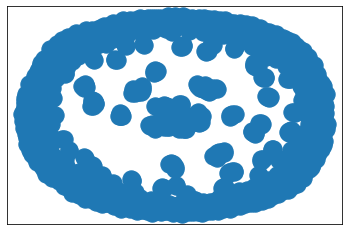

In [33]:
pos=nx.spring_layout(G)
nx.draw_networkx(G,pos=pos, cmap=cmap)

## Generate stellar graph

In [ ]:
Stellar_G = StellarGraph.from_networkx(G) 

## Node2Vec algorithm

The Node2Vec algorithm is a 2-step representation learning algorithm. The two steps are:
1. Use second-order random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a **corpus**.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The **Word2Vec** algorithm, is used for calculating the embedding vectors.

In [ ]:
# load saved embeddings(.txt) as dict
def load_embeddings(file_path):
    embedding_dict = {}
    first_line = True
    with open(file_path) as f:
        for line in f:
            if first_line:
                first_line = False
                continue
            vector = [float(i) for i in line.strip().split()]
            embedding_dict[int(vector[0])] = vector[1:]
        f.close()
    return embedding_dict

# two steps Node2Vec algorithm
# also get to choose recalculating embeddings / use existing ones
def calculate_embeddings(recalculate_embeddings, G, txt_embeddings_file_path):
    if recalculate_embeddings==True: #calculate emebeddings, or else use existing ones
        # 1. perform random walk to generate corpus 
        rw = BiasedRandomWalk(G)
        walks = rw.run(
            nodes=list(G.nodes()),  # root nodes
            length=32,  # maximum length of a random walk
            n=10,  # number of random walks per root node
            p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
            q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
            seed=42 # make random walk predictable
        )
        print("Number of random walks: {}".format(len(walks)))
        
        # 2. perform Word2Vec to learn embedding vectors and save as .txt
        str_walks = [[str(n) for n in walk] for walk in walks]
        model = Word2Vec(str_walks, vector_size=128, window=5, 
                         min_count=0, sg=1, workers=2, epochs=1)
        model.wv.save_word2vec_format(txt_embeddings_file_path) #save to path as .txt
        
    return load_embeddings(txt_embeddings_file_path)

## Classifier - logistic regressiond function
during test rain can choose dict / node embeddings 

In [ ]:
def split_data(G, embeddings):
    X = []
    y = []
    for x in embeddings.keys():
        X.append(embeddings[x]) #embeddings value of the key
        y.append(G.nodes[x]['label_class']) #binary classifier 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test


def train_classifier(X_train, y_train):
    clf = LogisticRegressionCV(
        Cs=10, cv=10, scoring="accuracy", verbose=False, max_iter=3000
    )
    clf.fit(X_train, y_train)
    return clf


def test_classifier(X_test, y_test, clf):
    y_pred = clf.predict(X_test)
    print(f"Accuracy classification score: {accuracy_score(y_test, y_pred)}")

## Downstream tasks 

In [ ]:
embeddings = calculate_embeddings(True, Stellar_G, 'embeddings.txt')
#X_train, X_test, y_train, y_test = split_data(G, embeddings)
#clf = train_classifier(X_train, y_train)
#test_classifier(X_test, y_test, clf)


In [ ]:
len(embeddings.keys())

In [ ]:
len(list(G.nodes))

## Visualize with networkx - community detection + color algorithm 